In [1]:
!CXXFLAGS+=-stdlib=libc++ maturin develop --release

🔗 Found pyo3 bindings
🐍 Found CPython 3.11 at /Users/josh/josh/projects/tech/flow/.venv/bin/python
💻 Using `MACOSX_DEPLOYMENT_TARGET=10.7` for x86_64-apple-darwin by default
   Compiling flow v0.1.0 (/Users/josh/josh/projects/tech/flow)
    Finished release [optimized + debuginfo] target(s) in 11.16s              
📦 Built wheel for CPython 3.11 to /var/folders/w9/c8qym84j2pg4fjvx_bzr84bc0000gn/T/.tmpqZKFb8/flow-0.1.0-cp311-cp311-macosx_10_7_x86_64.whl
🛠 Installed flow-0.1.0


t: 4.1050, CFL margin: 51.9324:  82%|████████▏ | 822/1000 [00:49<00:10, 16.71it/s]       


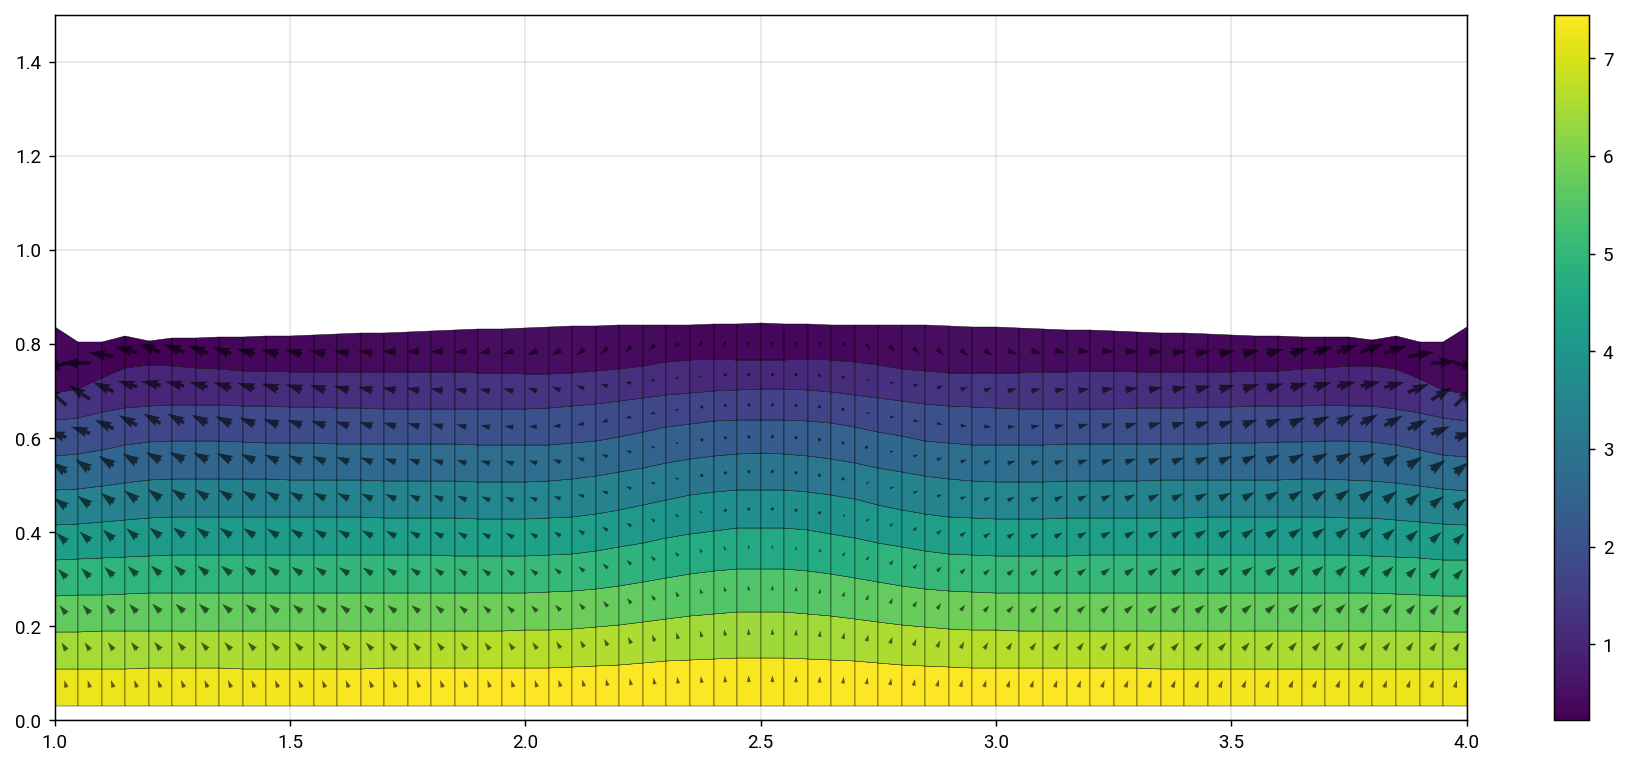

In [2]:
import contextplot
import matplotlib
import matplotlib.collections
import matplotlib.patches
import numpy as np
import tqdm

import flow

contextplot.set_defaults()

example = 'bump_1d'
# example = 'singularity_1d'

num_cells = 60
solver = getattr(flow, example)(num_cells, 10)

dt = 0.005

with contextplot.context_video(f'videos/{example}.mp4', 1, size_inches=(5.5*2, 2.5*2), frame_rate_hz=15) as cv:
    try:
        bar = tqdm.tqdm(range(1000))
        for step in bar:
            if step % 6 == 0:
                with cv.next_frame() as cp:
                    z_lattice = solver.z_lattice
                    x_vertices = solver.grid.x_axis.vertices
                    x_centers = solver.grid.x_axis.centers
                    # pressure = solver.volume_time_deriv
                    pressure = solver.pressure
                    velocity = solver.velocity

                    poly_verts = []
                    pressures = []
                    for i in range(z_lattice.shape[0] - 1):
                        for j in range(z_lattice.shape[2] - 1):
                            poly_verts.append([
                                [x_vertices[i], z_lattice[i, 0, j]],
                                [x_vertices[i + 1], z_lattice[i + 1, 0, j]],
                                [x_vertices[i + 1], z_lattice[i + 1, 0, j + 1]],
                                [x_vertices[i], z_lattice[i, 0, j + 1]],
                            ])
                            pressures.append(pressure[i, 0, j, 1])
                    poly_collection = matplotlib.collections.PolyCollection(
                        poly_verts, closed=True, array=pressures, cmap=matplotlib.cm.viridis, edgecolors='black', linewidth=0.2, snap=True)
                    outs = cp.ax_raw.add_collection(poly_collection)
                    _ = cp.figure.colorbar(outs)

                    cp.ax.quiver(
                        np.broadcast_to(x_centers[:, np.newaxis], z_lattice[:-1, 0, :-1].shape),
                        0.25 * (z_lattice[:-1, 0, :-1] + z_lattice[1:, 0, :-1] + z_lattice[:-1, 0, 1:] + z_lattice[1:, 0, 1:]),
                        velocity[:, 0, :, 0, 0],
                        velocity[:, 0, :, 0, 2],
                        pivot='tail',
                        scale=1,
                        scale_units='inches',
                        alpha=0.6,
                    )

                    # cp.ax.plot(x_centers, 1 + solver.height_time_deriv[:, 0, 0], 'k')
                    # cp.ax.plot(x_centers, 1 + solver.height_time_deriv[:, 0, 1], 'k--')

                    cp.ax.set(xlim=[solver.grid.x_axis.vertices[0], solver.grid.x_axis.vertices[-1]], ylim=[0, 1.5], aspect='equal')
            _ = bar.set_description(f't: {step * dt:.4f}, CFL margin: {solver.courant_dt / dt:.4f}', 50)

            solver.step(dt)
    except KeyboardInterrupt:
        pass
    except BaseException:
        pass

In [2]:
(pressure[5, 0, 1, 1] - pressure[5, 0, 0, 1]) / (z_lattice[5, 0, 1] - z_lattice[5, 0, 0])

nan